In [2]:
import sys
from time import time
from time import sleep
import itertools

import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append('..')
import numcodecs
from numcodecs.blosc import Blosc
from numcodecs.compat import ensure_bytes, ensure_ndarray

In [3]:
def time_partial(dtype, enc, start, nitems, to_array=False):
    start_time = time()
    decoded = codec.decode_partial(enc, start, nitems)
    if to_array:
       ensure_ndarray(decoded).view(dtype)
    stop_time = time()
    return stop_time - start_time

def time_full(dtype, enc, start, nitems, to_array=False):
    start_time = time()
    decoded = codec.decode(enc)
    if to_array:
       darr = ensure_ndarray(decoded).view(dtype)
       darr[start:start+nitems]
    stop_time = time()
    return stop_time - start_time

def compare(arr_size, dtype, codec, start, steps, ntimes, to_array=False):
    arr = np.arange(arr_size, dtype=dtype)
    enc = codec.encode(arr)

    col_name = f'{arr_size}{dtype}|{str(codec)}|{to_array}'

    res = []
    dtype = arr.dtype
    for x in range(start+1, arr.size, steps):
        for y in range(ntimes):
            full_eval_time = time_full(dtype, enc, start, x, to_array=to_array)
            partial_eval_time = time_partial(dtype, enc, start, x)
            res.append((col_name, x, y, partial_eval_time, full_eval_time))
    df = pd.DataFrame(res, columns=['group','nitems', 'round', 'partial_decode', 'full_decode'])
    gb = df.groupby(['group', 'nitems'], as_index=False).mean()
    gb['percent_time'] = df.partial_decode / df.full_decode
    gb = gb[['group', 'nitems', 'percent_time']]
    gb['codec'] = str(codec)
    gb['arr_size'] = arr_size
    gb['dtype'] = str(dtype)
    return gb


In [32]:
codecs2 = [
    Blosc(shuffle=Blosc.SHUFFLE),
    Blosc(clevel=0, shuffle=Blosc.SHUFFLE),
    Blosc(cname='lz4', shuffle=Blosc.SHUFFLE),
    Blosc(cname='lz4', clevel=1, shuffle=Blosc.NOSHUFFLE),
    Blosc(cname='lz4', clevel=9, shuffle=Blosc.BITSHUFFLE),
    Blosc(cname='zlib', clevel=1, shuffle=0),
    Blosc(cname='zstd', clevel=1, shuffle=1),
    Blosc(cname='blosclz', clevel=1, shuffle=2),
    Blosc(cname='snappy', clevel=1, shuffle=2),
    Blosc(shuffle=Blosc.SHUFFLE, blocksize=0),
    Blosc(shuffle=Blosc.SHUFFLE, blocksize=2**8),
    Blosc(cname='lz4', clevel=1, shuffle=Blosc.NOSHUFFLE, blocksize=2**8),
]
arr_sizes = [10000, 50_000, 100_000]
dtypes = ['i4', 'i8']
encoding_sizes = [-1]
to_arrays = [False]

combos = itertools.product(codecs2, arr_sizes, dtypes, to_arrays)

comparisons = []
for codec, arr_size, dtype, to_array in combos:
    data = compare(arr_size, dtype, codec, 0, int(arr_size/10), 1000, to_array=to_array)
    comparisons.append(data)

df = pd.concat(comparisons)

The below visuals show the fraction of time that partial decompress took relative to
a full decompress. So a value of 1 means that the partial_decode method on average took
the same amount of time as the full decode. a value of .5 would mean that it took half
the time. 

Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)


Blosc(cname='lz4', clevel=0, shuffle=SHUFFLE, blocksize=0)


Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)


Blosc(cname='lz4', clevel=1, shuffle=NOSHUFFLE, blocksize=0)


Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)


Blosc(cname='lz4', clevel=9, shuffle=BITSHUFFLE, blocksize=0)


Blosc(cname='zlib', clevel=1, shuffle=NOSHUFFLE, blocksize=0)


Blosc(cname='zstd', clevel=1, shuffle=SHUFFLE, blocksize=0)


Blosc(cname='blosclz', clevel=1, shuffle=BITSHUFFLE, blocksize=0)


Blosc(cname='snappy', clevel=1, shuffle=BITSHUFFLE, blocksize=0)


Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)


Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=256)


Blosc(cname='lz4', clevel=1, shuffle=NOSHUFFLE, blocksize=256)


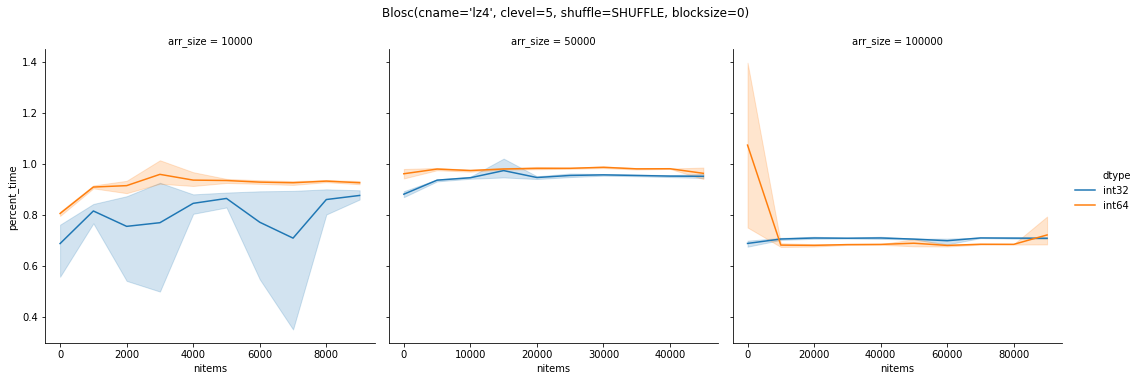

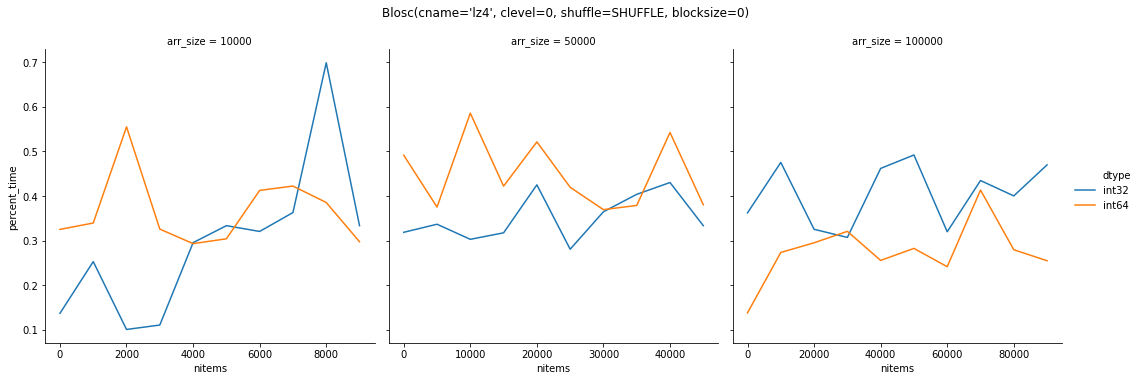

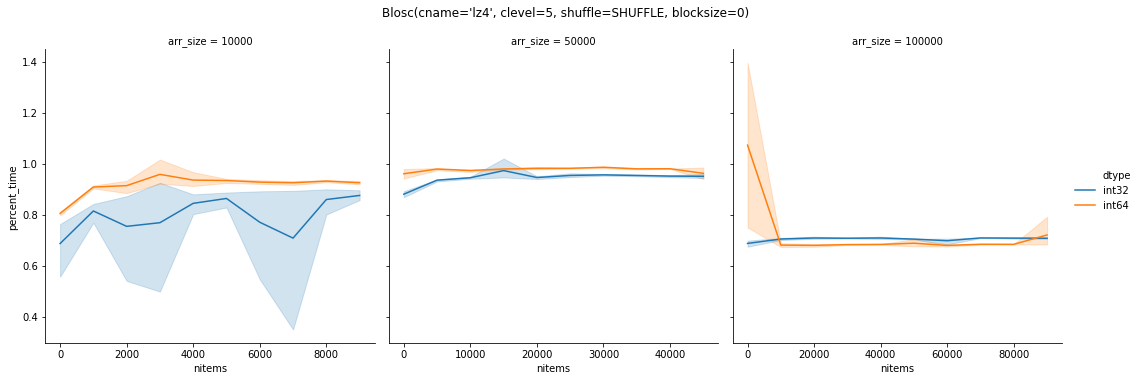

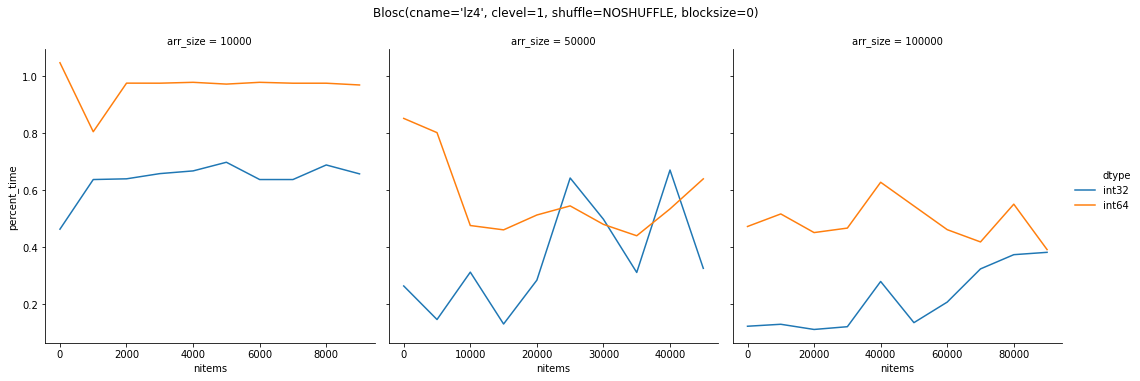

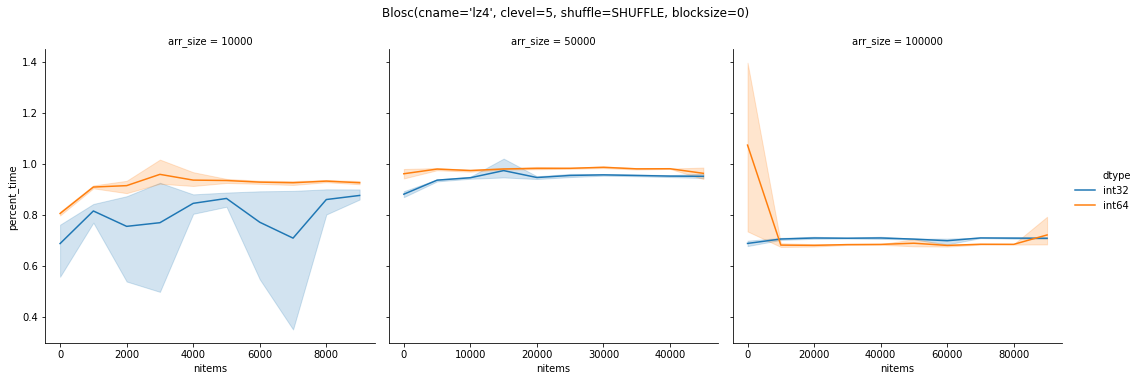

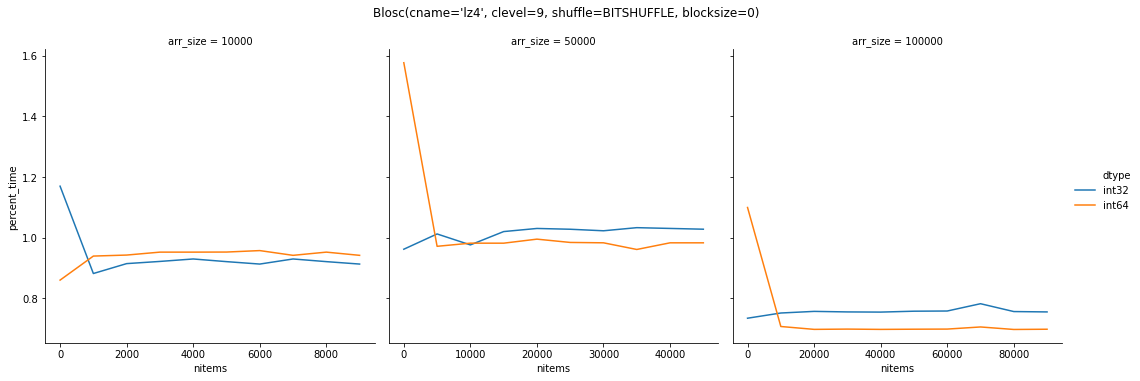

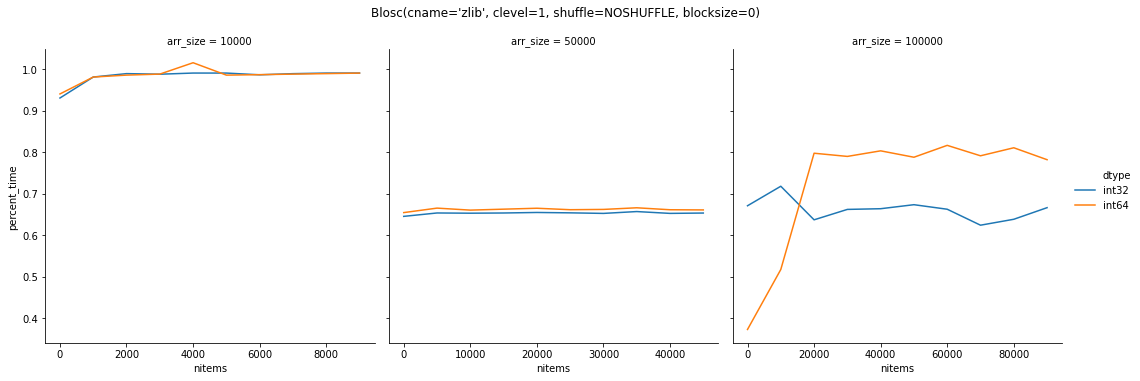

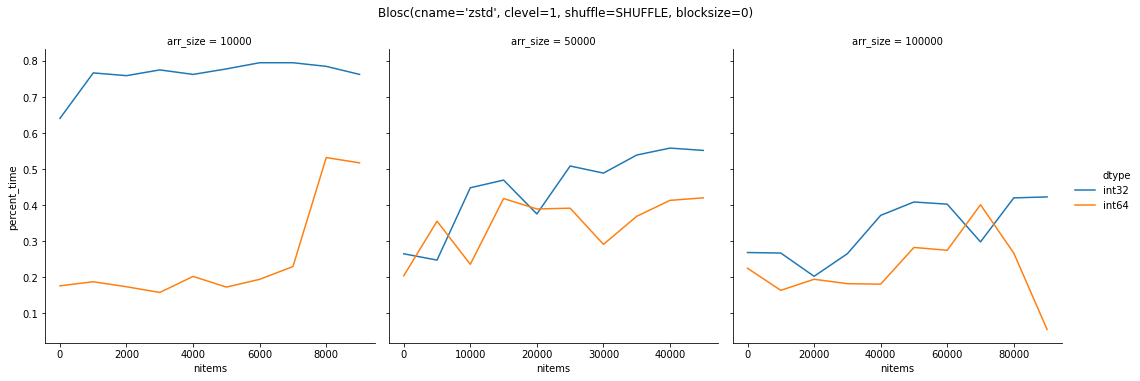

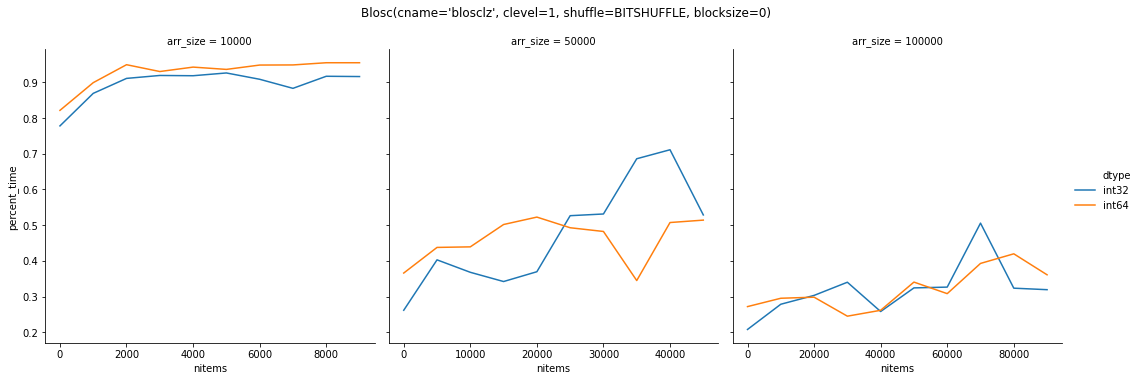

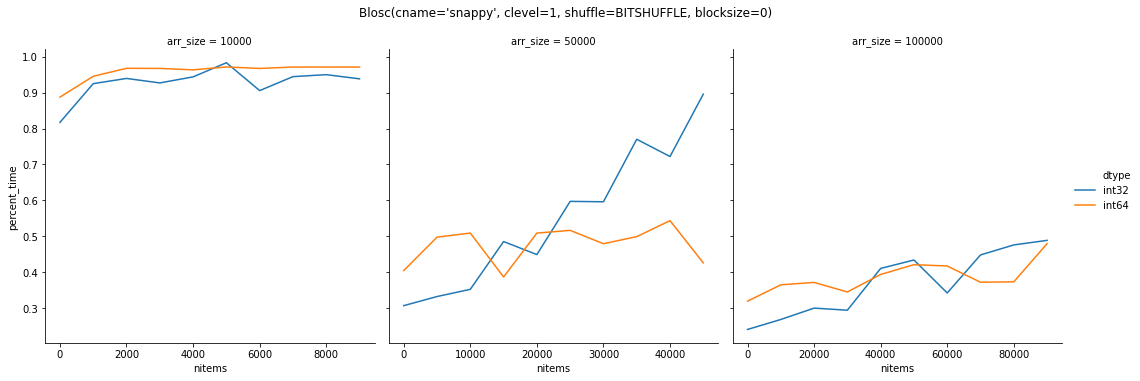

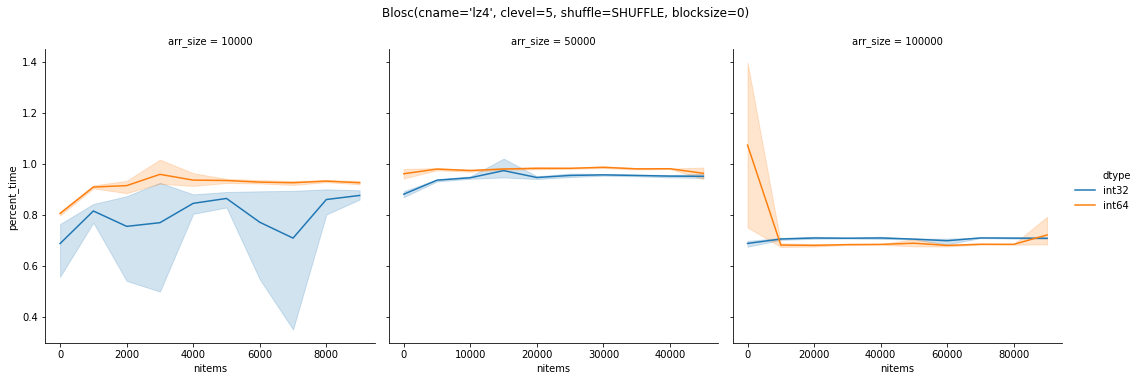

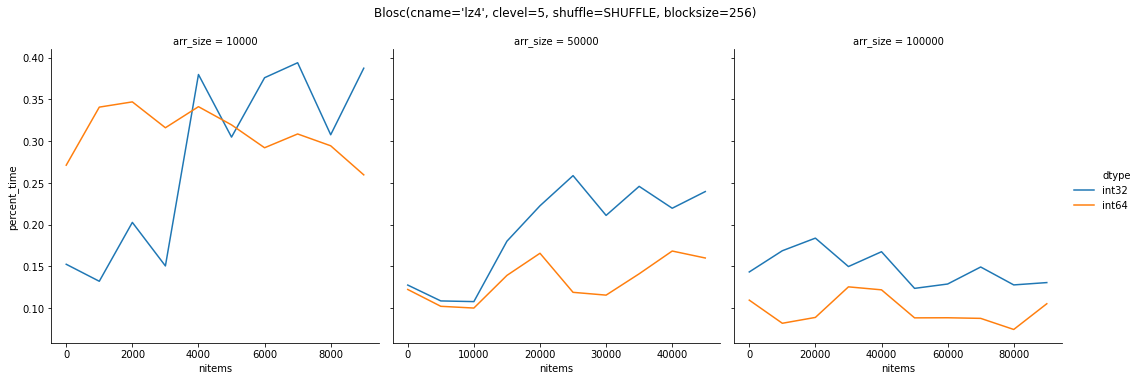

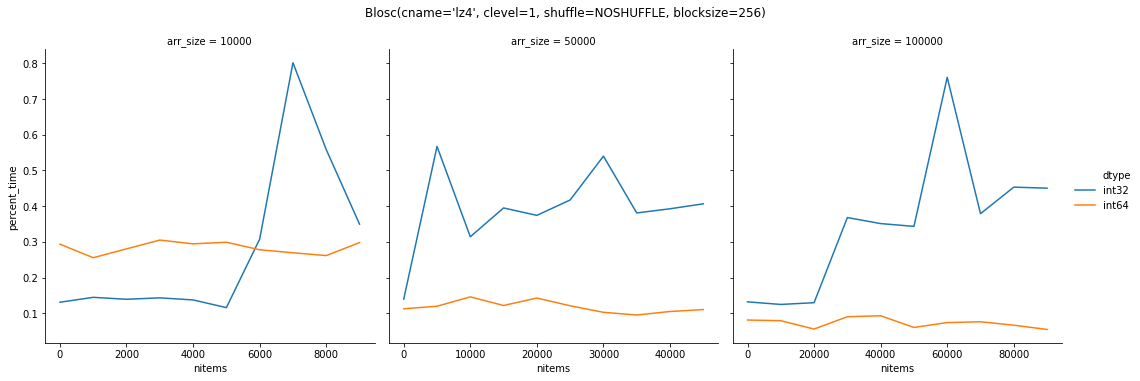

In [31]:
codec_strs = [str(codec) for codec in codecs2]

for codec in codec_strs:
    print(codec)
    plot = sns.relplot(x='nitems', y='percent_time', hue='dtype', col="arr_size", data=df[df.codec==codec], kind="line", legend='full', facet_kws=dict(sharex=False))
    plot.fig.suptitle(codec, y=1.05)

In [22]:
codec = codec_strs[0]
plot = sns.relplot(x='nitems', y='percent_time', hue='dtype', col="arr_size", data=df[df.codec==codec], kind="line", legend='full', facet_kws={})
plot.fig.suptitle(codec, y=1)

ValueError: figure size must be positive finite not (0, 5)

In [25]:
df.codec.unique()

array(["Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)",
       "Blosc(cname='lz4', clevel=0, shuffle=SHUFFLE, blocksize=0)",
       "Blosc(cname='lz4', clevel=1, shuffle=NOSHUFFLE, blocksize=0)",
       "Blosc(cname='lz4', clevel=9, shuffle=BITSHUFFLE, blocksize=0)",
       "Blosc(cname='zlib', clevel=1, shuffle=NOSHUFFLE, blocksize=0)",
       "Blosc(cname='zstd', clevel=1, shuffle=SHUFFLE, blocksize=0)",
       "Blosc(cname='blosclz', clevel=1, shuffle=BITSHUFFLE, blocksize=0)",
       "Blosc(cname='snappy', clevel=1, shuffle=BITSHUFFLE, blocksize=0)",
       "Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=256)",
       "Blosc(cname='lz4', clevel=1, shuffle=NOSHUFFLE, blocksize=256)"],
      dtype=object)

In [24]:
codec

'Blosc(shuffle=Blosc.SHUFFLE)'

In [15]:
codec_strs[0]

'Blosc(shuffle=Blosc.SHUFFLE)'